# Connect Four boardgame AI

In this notebook we construct the boardgame "Connect Four" as a Python class and implement Monte Carlo Tree Simulation (MCTS) to learn an AI opponent.

In [18]:
#Import relevant packages

import numpy as np
import pandas as pd
import random
import copy
import math
import matplotlib.pyplot as plt
from matplotlib import colors

from IPython.display import clear_output

## 1. The `ConnectFour` class

The following cell implements the `ConnectFour` class; each `ConnectFour` object represents a game of Connect Four.  An object's primary attributes are: a board state `self.board_state`, the turn `self.turn` of the game, the status of the game `self.is_won`, the legal moves the active player can play `self.legal_moves`, and the location of the previous chip's placement `self.last_move`.

To play a chip for the active player in column `col`, one issues the `self.play_chip(col)` function.

In [10]:
class ConnectFour:
    win_length = 4
    num_rows = 6
    num_cols = 7

    #Each ConnectFour object is a board_state, which is an array
    #of 0's (empty squares), 1's (red chips) and -1's (black chips).
    #The red chips are played on even turns (initial turn is turn 0), black chips on odd turns.
    def __init__(self):
        #On initialization, the board_state is empty, the turn is 0, the game is not won, all moves are legal, and the last move is nonsense.
        self.board_state = np.zeros((self.num_rows,self.num_cols), dtype=int)
        self.turn = 0
        self.is_won = False
        self.is_over = False
        self.legal_moves = np.arange(7)
        self.last_move = (-1,-1)
        
    def reset(self):
        #self.reset resets all the game parameters to their initial state.
        self.board_state = np.zeros((self.num_rows,self.num_cols), dtype=int)
        self.turn = 0
        self.is_won = False
        self.is_over = False
        self.legal_moves = np.arange(7)
        self.last_move = (-1,-1)

    def play_chip(self, column):
        #First check if the game is over:
        if self.is_won == True:
            print('The game is over; %s has won.' % self.winner)
        elif (self.is_won == False and self.legal_moves.size == 0):
            print('The game has ended in a draw.')            
        else:
            #Player whose turn it is places a chip in column
            #Determine whose turn it is:
            if self.turn % 2 == 0:
                chip = 1
            else:
                chip = -1

            #If suggested move is legal, play the chip in column and go to next turn.
            if column in self.legal_moves:
                self.last_move = np.amax(np.where(self.board_state[:,column] == 0)),column
                self.board_state[self.last_move] = chip
                self.turn += 1
            else:
                print('Column is full; please suggest another move.')


            #Check to see if the game has been won:
            self.check_win()
            
            #Redetermine the legal moves in the board_state:
            self.legal_moves = np.where(self.board_state[0]==0)[0]
            
            if self.is_won == True:
                print('The game is over; %s wins!' % self.winner)
                self.is_over = True
            elif (self.is_won == False and self.legal_moves.size == 0):
                print('The game has ended in a draw.')
                self.is_over = True

    def check_win(self):
        #Checks for a winning position for both players relative to self.last_move:
        y,x = self.last_move

        #Check for column wins containing self.last_move (there can be only one):
        if (y <= self.num_rows - self.win_length):
            sum_temp = 0
            for k in range(0,self.win_length):
                sum_temp += self.board_state[y+k][x]
            if sum_temp == self.win_length:
                self.winner = 'Player 1'
                self.is_won = True
                return
            elif sum_temp == -self.win_length:
                self.winner = 'Player 2'
                self.is_won = True
                return

        #Check for row wins containing self.last_move:
        for i in range(0,self.win_length):
            if (x-i <= self.num_cols - self.win_length and x-i >= 0):
                sum_temp = 0
                for k in range(0,self.win_length):
                    sum_temp += self.board_state[y][x-i+k]
                if sum_temp == self.win_length:
                    self.winner = 'Player 1'
                    self.is_won = True
                    return
                elif sum_temp == -self.win_length:
                    self.winner = 'Player 2'
                    self.is_won = True
                    return

        #Check for diagonal \\ wins containing self.last_move:
        for i in range(0,self.win_length):
            if (x-i <= self.num_cols-self.win_length and x-i >=0 and y-i <= self.num_rows - self.win_length and y-i >= 0):
                sum_temp = 0
                for k in range(0,self.win_length):
                    sum_temp += self.board_state[y-i+k][x-i+k]
                if sum_temp == self.win_length:
                    self.winner = 'Player 1'
                    self.is_won = True
                    return
                elif sum_temp == -self.win_length:
                    self.winner = 'Player 2'
                    self.is_won = True
                    return

        #Check for diagonal // wins containing self.last_move:
        for i in range(0,self.win_length):
            if (x-i <= self.num_cols-self.win_length and x-i >= 0 and y+i > self.num_rows - self.win_length and y+i <= 5):
                sum_temp = 0
                for k in range(0,self.win_length):
                    sum_temp += self.board_state[y+i-k][x-i+k]
                if sum_temp == self.win_length:
                    self.winner = 'Player 1'
                    self.is_won = True
                    return
                elif sum_temp == -self.win_length:
                    self.winner = 'Player 2'
                    self.is_won = True
                    return

We instantiate a sample game and play a few moves below:

In [15]:
game = ConnectFour()

game.play_chip(0)
game.play_chip(1)
game.play_chip(0)

game.board_state

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 1, -1,  0,  0,  0,  0,  0]])

## 2. A user-friendly implementation

Below we create a simple user-friendly implementation, where Python continually requests inputs from players.

First, we introduce simple function to display the game's board state:

In [50]:
# create discrete colormap
cmap = colors.ListedColormap(['k', 'w', 'r'])
bounds = [-1,0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

def plot_matrix(rm, title='Connect Four'):
    fig, ax = plt.subplots()
    ax.imshow(rm, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(-.5, 7, 1));
    ax.set_yticks(np.arange(-.5, 6, 1));
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

    plt.show()

The game is over; Player 2 wins!
The final position:



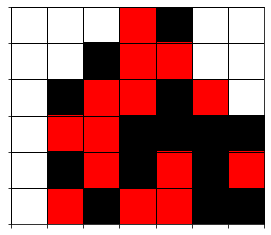

In [52]:
game = ConnectFour()

while(game.is_over == False):
    plot_matrix(game.board_state)
    
    current_player = str((game.turn % 2)+1)
    print('Player %s, it is your turn.\n' % current_player)
    next_move = int(input('Enter a column (1-7) to play a move:'))-1
    if (next_move in game.legal_moves):
            game.play_chip(next_move)
    else:
        print('Please enter a valid command.')
    clear_output()

if (game.is_won == True):
    print('The game is over; %s wins!' % game.winner)
elif (game.is_won == False and self.legal_moves.size == 0):
    print('The game has ended in a draw.')

print('The final position:\n')
plot_matrix(game.board_state)

game.reset()